# Drop-in systems

Biorefinery systems can be created by connecting smaller systems, allowing us to create alternative configurations with ease. 

### System factories

This section is just to get you familiar with [SystemFactory](../process_tools/SystemFactory.txt) objects. Don’t worry if you don’t fully understand. The main idea is that SystemFactory objects return a System object when called and have a signature of `f(ID=None, ins=None, outs=None, area=None, udct=None, *args, **kwargs)`, where the system `ID` is a string, `ins` are the inlet streams, and `outs` are the outlet streams (similar to unit operations). The `area` and `udct` parameter will be discussed later. You can therefore call a SystemFactory object without any parameters. Let's first have a look at some of the system factories in the [biorefineries.sugarcane](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park/tree/master/BioSTEAM%202.x.x/biorefineries/sugarcane) library:  

In [1]:
# Import system factories
from biorefineries.sugarcane import (
    create_juicing_system_with_fiber_screener as create_juicing_system,
    create_sucrose_to_ethanol_system 
)
create_juicing_system.show(); print(); create_sucrose_to_ethanol_system.show() 

SystemFactory(
    f=<create_juicing_system_with_fiber_screener(ins, outs)>,
    ID='juicing_sys',
    ins=[dict(ID='sugarcane',
              Water=0.7,
              Glucose=0.01208,
              Sucrose=0.1369,
              Ash=0.006,
              Cellulose=0.06115,
              Hemicellulose=0.03608,
              Lignin=0.03276,
              Solids=0.015,
              total_flow=333334.2,
              units='kg/hr',
              price=0.03455),
         dict(ID='enzyme',
              Cellulose=100,
              Water=900,
              units='kg/hr',
              price=0.5),
         dict(ID='H3PO4',
              H3PO4=74.23,
              Water=13.1,
              units='kg/hr',
              price=0),
         dict(ID='lime',
              CaO=333.0,
              Water=2200.0,
              units='kg/hr',
              price=0.077),
         dict(ID='polymer',
              Flocculant=0.83,
              units='kg/hr',
              price=0)],
    outs=[dict(ID='scr

[SystemFactory](../process_tools/SystemFactory.txt) objects have a predefined system `ID` and use keyword arguments to generate default `ins` and `outs` for the system. Hopefully things will be become clearer as we start to use system factories in the following sections…

### Using drop-in systems

As an example, here we create a sugarcane to ethanol production system without facilities (e.g., cooling tower, boiler) by using system factories:

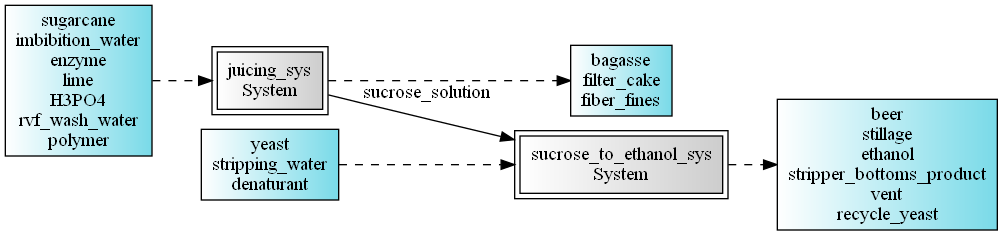

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.27 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  491
                 Octane   4.39


In [2]:
from biorefineries.sugarcane import chemicals
from biosteam import Stream, System, settings

settings.set_thermo(chemicals)
sucrose_solution = Stream('sucrose_solution')
denaturant = Stream('denaturant',
                    Octane=230.69,
                    units='kg/hr',
                    price=0.756)
enzyme = Stream('enzyme',
                Cellulose=100,
                Water=900,
                units='kg/hr',
                price=0.5)

juicing_sys = create_juicing_system(
    ins=[None, enzyme], # Place enzyme in the 1st inlet (sugarcane and all other inlets are defaulted)
    outs=[sucrose_solution], # Place sucrose_solution at the 0th outlet (all others are defaulted)
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(ins=[sucrose_solution, denaturant]) 

# Here are a couple of other ways to connect systems:
#   Manually:
#   >>> sucrose_to_ethanol_sys.ins[0] = juicing_sys.outs[0]
#   With -pipe- notation:
#   >>> juicing_sys-0-0-sucrose_to_ethanol_sys 

# Create a new system, and simulate
sugarcane_to_ethanol_sys = System('sugarcane_to_ethanol_sys', [juicing_sys, sucrose_to_ethanol_sys])
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.diagram()
sucrose_to_ethanol_sys.outs[0].show()

Let's have a look at all the inlets and outlets of the new system:

In [3]:
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
ins...
[0] imbibition_water
[1] sugarcane
[2] enzyme
[3] rvf_wash_water
[4] H3PO4
[5] lime
[6] missing stream
[7] polymer
[8] missing stream
[9] stripping_water
[10] denaturant
[11] yeast
[12] missing stream
outs...
[0] filter_cake
[1] fiber_fines
[2] bagasse
[3] recycle_yeast
[4] vent
[5] beer
[6] stillage
[7] stripper_bottoms_product
[8] ethanol


The number of inlets (9) and outlets (10) are rather large. It may be helpful to specify what inlets and outlets do we want to expose:

In [4]:
ins = sugarcane_to_ethanol_sys.ins
outs = sugarcane_to_ethanol_sys.outs
sugarcane_to_ethanol_sys.load_inlet_ports([ins[1]])
sugarcane_to_ethanol_sys.load_outlet_ports([outs[8], outs[2]])
sugarcane_to_ethanol_sys.show(data=False)

System: sugarcane_to_ethanol_sys
ins...
[0] sugarcane
outs...
[0] ethanol
[1] bagasse


### Saving time with mock systems

When creating a biorefinery, we may not be interested in all the subsystems we create along the way with SystemFactory objects. We can save a few milliseconds in computational time (per system) by using mock systems:

In [5]:
from biosteam import main_flowsheet

main_flowsheet.clear() # Remove previous unit operations
juicing_sys = create_juicing_system(
    ins=[None, enzyme], 
    outs=[sucrose_solution],
    mockup=True
) 
sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(
    ins=[sucrose_solution, denaturant],
    mockup=True
) 
# Note that mock systems don't have anything other than `ins`, `outs`, and `units` 
juicing_sys.show()
sucrose_to_ethanol_sys.show()

MockSystem(
    ins=[0-T201, 1-T201, 1-T203, 0-T204, 1-T206],
    outs=[S202-0, U202-0, S202-1],
    units=[T201, U201, U202, M201, S201,
           T202, H201, T203, P201, T204,
           T205, P202, M202, H202, T206,
           C201, C202, P203, S202]
)
MockSystem(
    ins=[0-S301, 0-T303],
    outs=[T304-0, H302-1, P303-0, F301-1],
    units=[S301, F301, M301, H301, R301,
           T301, D301, C301, M302, T305,
           P306, P301, D302, P302, H302,
           M303, D303, P303, H303, U301,
           H304, T302, P304, T303, P305,
           M304, T304]
)


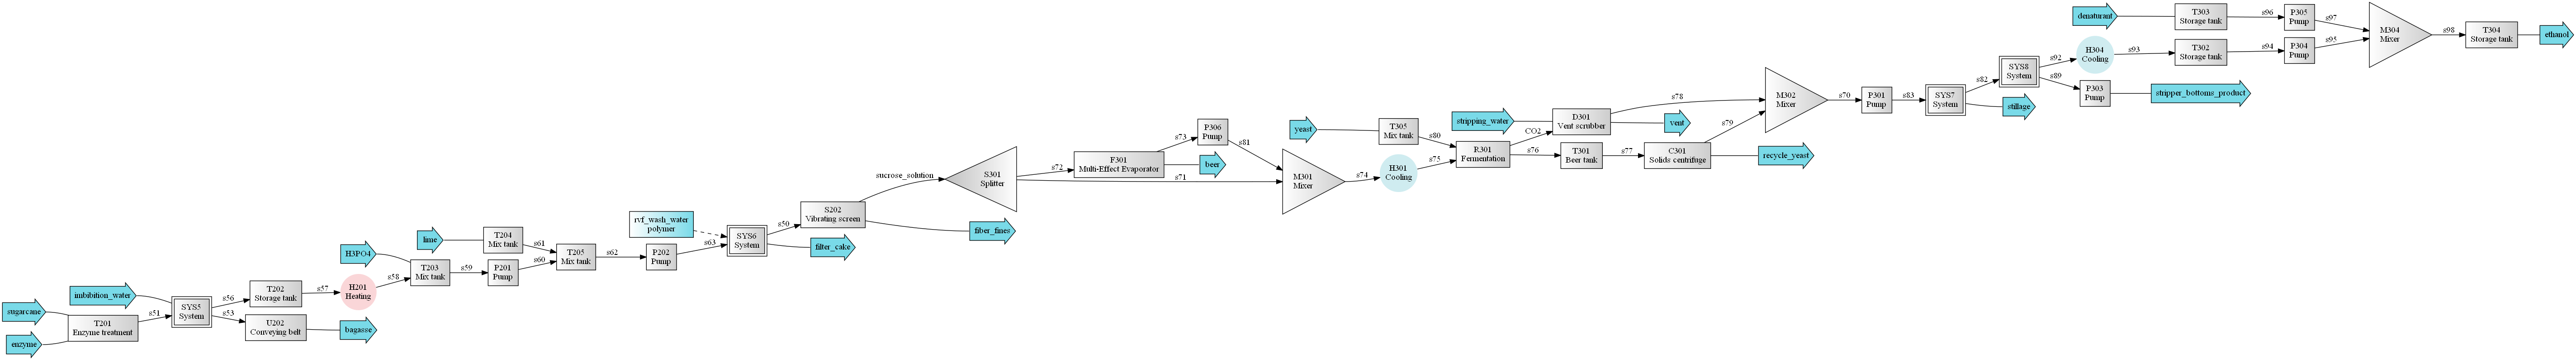

Stream: ethanol from <StorageTank: T304>
 phase: 'l', T: 339.27 K, P: 101325 Pa
 flow (kmol/hr): Water    10.4
                 Ethanol  491
                 Octane   4.39


In [6]:
# We can create the system using the flowsheet
sugarcane_to_ethanol_sys = main_flowsheet.create_system('sugarcane_to_ethanol_sys')
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.diagram()
sucrose_to_ethanol_sys.outs[0].show()

### Area naming convention for unit operations

The area naming convention follows {letter}{area + number} where the letter depends on
the unit operation as follows:
* C: Centrifuge
* D: Distillation column
* E: Evaporator
* F: Flash tank
* H: Heat exchange
* M: Mixer
* P: Pump (including conveying belt)
* R: Reactor
* S: Splitter (including solid/liquid separator)
* T: Tank or bin for storage
* U: Other units
* J: Junction, not a physical unit (serves to adjust streams)
* PS = Process specificiation, not a physical unit (serves to adjust streams)

For example, the first mixer in area 100 would be named M101. When calling a SystemFactory object, we can pass the `area` to name unit operations according the area convention. In the following example, we name all unit operations in the juicing system under area 300:

In [7]:
main_flowsheet.clear() # Remove previous unit operations
juicing_sys = create_juicing_system(area=300, mockup=True) 
juicing_sys.show()

MockSystem(
    ins=[0-T301, 1-T301, 1-T303, 0-T304, 1-T306],
    outs=[S305-0, U301-0, S305-1],
    units=[T301, S301, U301, M301, S302,
           T302, H301, T303, P301, T304,
           T305, P302, M302, H302, T306,
           S303, S304, P303, S305]
)


To access unit operations by their defaults ID (as originally defined in SystemFactory code), you can request a unit dictionary by passing `udct`=True:

In [8]:
main_flowsheet.clear() # Remove previous unit operations
# Two arguments, the system and the unit dictionary are returned when udct is True
juicing_sys, udct = create_juicing_system(mockup=True, area=300, udct=True) 
unit = udct['T201']
print(repr(unit)) # Originally, this unit was named T201

<EnzymeTreatment: T301>


### Making system factories

Create a SystemFactory object for creating sugarcane to ethanol systems: 

In [9]:
from biosteam import System, SystemFactory

@SystemFactory(
    ID='sugarcane_to_ethanol_sys',
    ins=[create_juicing_system.ins[0],
         create_sucrose_to_ethanol_system.ins[1]],
    outs=[create_sucrose_to_ethanol_system.outs[0],
          create_juicing_system.outs[1]]
)
def create_sugarcane_to_ethanol_system(ins, outs):
    # ins and outs will be stream objects
    sugarcane, denaturant = ins
    ethanol, bagasse = outs
    juicing_sys = create_juicing_system(
        ins=sugarcane, 
        outs=[None, bagasse], # None will default to a stream
        mockup=True
    ) 
    sucrose_to_ethanol_sys = create_sucrose_to_ethanol_system(
        ins=(juicing_sys-0, denaturant),
        outs=ethanol,
        mockup=True,
    )
    # The system factory builds a system from units created by the function

create_sugarcane_to_ethanol_system.show()

SystemFactory(
    f=<create_sugarcane_to_ethanol_system(ins, outs)>,
    ID='sugarcane_to_ethanol_sys',
    ins=[dict(ID='sugarcane',
              Water=0.7,
              Glucose=0.01208,
              Sucrose=0.1369,
              Ash=0.006,
              Cellulose=0.06115,
              Hemicellulose=0.03608,
              Lignin=0.03276,
              Solids=0.015,
              total_flow=333334.2,
              units='kg/hr',
              price=0.03455),
         dict(ID='denaturant',
              Octane=230.69,
              units='kg/hr',
              price=0.756)],
    outs=[dict(ID='ethanol',
               price=0.789),
          dict(ID='bagasse')]
)


Create the sugarcane to ethanol system and simulate:

In [10]:
main_flowsheet.clear() # Remove previous unit operations
sugarcane_to_ethanol_sys = create_sugarcane_to_ethanol_system()
sugarcane_to_ethanol_sys.simulate()
sugarcane_to_ethanol_sys.show()

System: sugarcane_to_ethanol_sys
ins...
[0] sugarcane
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water          1.3e+04
                    Glucose        22.4
                    Sucrose        133
                    Ash            2e+03
                    Cellulose      126
                    Hemicellulose  91
                    Lignin         71.8
                    ...
[1] denaturant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Octane  4.39
outs...
[0] ethanol
    phase: 'l', T: 339.27 K, P: 101325 Pa
    flow (kmol/hr): Water    10.4
                    Ethanol  491
                    Octane   4.39
[1] bagasse
    phase: 'l', T: 326.74 K, P: 101325 Pa
    flow (kmol/hr): Water          2.85e+03
                    Glucose        1.01
                    Sucrose        6.03
                    Ash            1.94e+03
                    Cellulose      123
                    Hemicellulose  88.3
                    Lignin         69.7
      

The [biorefineries](https://github.com/BioSTEAMDevelopmentGroup/Bioindustrial-Park) library has yet to fully implement SystemFactory objects across all functions that create systems, but that is the goal.